## Import dependencies

In [89]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

## Read in the data from the preprocessed csv

In [69]:
# Get the current directory of the notebook
current_dir = os.path.dirname(os.path.abspath(""))

# Navigate up two levels to reach the Project4 directory
project_dir = os.path.dirname(current_dir)

# Construct the absolute path to the CSV file
file_path = os.path.join(project_dir, "data/df_output/df_cleaned.csv")

# Load the CSV file
df_data = pd.read_csv(file_path)

# Show the df
df_data.head(2)

,IDUSGS,PLAYTYPE,WELLTYPE,FORMSIMPLE,TDS,LATITUDE,LONGITUDE,STATE,COUNTY,PROVINCE,...,FeTot,K,Li,Mg,Na,SO4,Sr,Zn,CHARGEBAL,BASIN_CATEGORY
0,63,Shale,Shale Gas,Marcellus,54800.0,40.441658,-79.986932,Pennsylvania,Allegheny,Appalachian Basin,...,27.40,0.0,21.5,295.0,12000.0,105.0,736.5,0.0839,-10.5,Appalachian
1,64,Shale,Shale Gas,Marcellus,26100.0,40.441658,-79.986932,Pennsylvania,Allegheny,Appalachian Basin,...,6.47,0.0,12.5,188.0,6920.0,116.0,215.0,0.0321,-3.0,Appalachian


In [70]:
df_data.columns

Index(['IDUSGS', 'PLAYTYPE', 'WELLTYPE', 'FORMSIMPLE', 'TDS', 'LATITUDE',
       'LONGITUDE', 'STATE', 'COUNTY', 'PROVINCE', 'REGION', 'WELLNAME', 'API',
       'DEPTHUPPER', 'DEPTHLOWER', 'PERIOD', 'DATESAMPLE', 'PH', 'B', 'Ba',
       'Br', 'HCO3', 'Ca', 'Cl', 'FeTot', 'K', 'Li', 'Mg', 'Na', 'SO4', 'Sr',
       'Zn', 'CHARGEBAL', 'BASIN_CATEGORY'],
      dtype='object')

In [71]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60658 entries, 0 to 60657
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   IDUSGS          60658 non-null  int64  
 1   PLAYTYPE        60658 non-null  object 
 2   WELLTYPE        60658 non-null  object 
 3   FORMSIMPLE      60658 non-null  object 
 4   TDS             60658 non-null  float64
 5   LATITUDE        60658 non-null  float64
 6   LONGITUDE       60658 non-null  float64
 7   STATE           60658 non-null  object 
 8   COUNTY          60026 non-null  object 
 9   PROVINCE        60658 non-null  object 
 10  REGION          60658 non-null  object 
 11  WELLNAME        54693 non-null  object 
 12  API             34447 non-null  float64
 13  DEPTHUPPER      47354 non-null  float64
 14  DEPTHLOWER      40757 non-null  float64
 15  PERIOD          48402 non-null  object 
 16  DATESAMPLE      46382 non-null  object 
 17  PH              45174 non-null 

## Generate KNN regression models for each basin for consideration

### ROUND 0 | Running on full data ILO by basin first to establish some basic logic as a starting point

In [72]:
# Drop unnecessary columns
# columns_to_drop = ['IDUSGS', 'PERIOD', 'DATESAMPLE', 'API']
columns_to_drop = ['IDUSGS', 'PERIOD', 'DATESAMPLE', 'API', 'Ba', 'Zn', 'B', 'FeTot', 'DEPTHLOWER', 'Sr', 'Br', 'HCO3']
df = df_data.drop(columns_to_drop, axis=1)
df.head(2)

,PLAYTYPE,WELLTYPE,FORMSIMPLE,TDS,LATITUDE,LONGITUDE,STATE,COUNTY,PROVINCE,REGION,...,PH,Ca,Cl,K,Li,Mg,Na,SO4,CHARGEBAL,BASIN_CATEGORY
0,Shale,Shale Gas,Marcellus,54800.0,40.441658,-79.986932,Pennsylvania,Allegheny,Appalachian Basin,Eastern,...,NaN,3140.0,31300.0,0.0,21.5,295.0,12000.0,105.0,-10.5,Appalachian
1,Shale,Shale Gas,Marcellus,26100.0,40.441658,-79.986932,Pennsylvania,Allegheny,Appalachian Basin,Eastern,...,NaN,1790.0,15300.0,0.0,12.5,188.0,6920.0,116.0,-3.0,Appalachian


In [73]:
df.dropna(subset=['Li'], inplace=True)
df.head(2)

,PLAYTYPE,WELLTYPE,FORMSIMPLE,TDS,LATITUDE,LONGITUDE,STATE,COUNTY,PROVINCE,REGION,...,PH,Ca,Cl,K,Li,Mg,Na,SO4,CHARGEBAL,BASIN_CATEGORY
0,Shale,Shale Gas,Marcellus,54800.0,40.441658,-79.986932,Pennsylvania,Allegheny,Appalachian Basin,Eastern,...,NaN,3140.0,31300.0,0.0,21.5,295.0,12000.0,105.0,-10.5,Appalachian
1,Shale,Shale Gas,Marcellus,26100.0,40.441658,-79.986932,Pennsylvania,Allegheny,Appalachian Basin,Eastern,...,NaN,1790.0,15300.0,0.0,12.5,188.0,6920.0,116.0,-3.0,Appalachian


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4131 entries, 0 to 60657
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PLAYTYPE        4131 non-null   object 
 1   WELLTYPE        4131 non-null   object 
 2   FORMSIMPLE      4131 non-null   object 
 3   TDS             4131 non-null   float64
 4   LATITUDE        4131 non-null   float64
 5   LONGITUDE       4131 non-null   float64
 6   STATE           4131 non-null   object 
 7   COUNTY          4011 non-null   object 
 8   PROVINCE        4131 non-null   object 
 9   REGION          4131 non-null   object 
 10  WELLNAME        3270 non-null   object 
 11  DEPTHUPPER      3293 non-null   float64
 12  PH              3123 non-null   float64
 13  Ca              4118 non-null   float64
 14  Cl              4131 non-null   float64
 15  K               4131 non-null   float64
 16  Li              4131 non-null   float64
 17  Mg              4093 non-null   float

In [75]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2142 entries, 285 to 59982
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PLAYTYPE        2142 non-null   object 
 1   WELLTYPE        2142 non-null   object 
 2   FORMSIMPLE      2142 non-null   object 
 3   TDS             2142 non-null   float64
 4   LATITUDE        2142 non-null   float64
 5   LONGITUDE       2142 non-null   float64
 6   STATE           2142 non-null   object 
 7   COUNTY          2142 non-null   object 
 8   PROVINCE        2142 non-null   object 
 9   REGION          2142 non-null   object 
 10  WELLNAME        2142 non-null   object 
 11  DEPTHUPPER      2142 non-null   float64
 12  PH              2142 non-null   float64
 13  Ca              2142 non-null   float64
 14  Cl              2142 non-null   float64
 15  K               2142 non-null   float64
 16  Li              2142 non-null   float64
 17  Mg              2142 non-null   flo

In [76]:
# One-hot encode categorical variables
categorical_columns = ['PLAYTYPE', 'WELLTYPE', 'FORMSIMPLE', 'STATE', 'COUNTY', 'PROVINCE', 'REGION', 'WELLNAME', 'BASIN_CATEGORY']
df = pd.get_dummies(df, columns=categorical_columns, dtype=int)
df.head(2)

,TDS,LATITUDE,LONGITUDE,DEPTHUPPER,PH,Ca,Cl,K,Li,Mg,...,BASIN_CATEGORY_Fort Worth,BASIN_CATEGORY_Great Plains,BASIN_CATEGORY_Gulf Coast,BASIN_CATEGORY_Illinois,BASIN_CATEGORY_Michigan,BASIN_CATEGORY_Oklahoma Platform,BASIN_CATEGORY_Pacific,BASIN_CATEGORY_Permian,BASIN_CATEGORY_Rocky Mountain,BASIN_CATEGORY_Williston
285,25200.0,29.55707,-97.78930,2582.0,6.5,1900.0,14000.0,130.0,7.7,580.0,...,0,0,1,0,0,0,0,0,0,0
286,127000.0,29.17289,-97.54256,11933.0,6.1,13000.0,76000.0,1100.0,120.0,1100.0,...,0,0,1,0,0,0,0,0,0,0


In [77]:
# Splitting the data into features (X) and the target variable (y)
y = df['Li'].copy()                   # Target variable
X = df.drop(columns=['Li']).copy()    # Features

In [78]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [79]:
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [80]:
# Define a range of k values to try
k_values = list(range(1, 21))

# Create a parameter grid
param_grid = {'n_neighbors': k_values}

# Perform grid search with cross-validation
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Get the best k value
best_k = grid_search.best_params_['n_neighbors']
print("Best k value:", best_k)

Best k value: 2


In [81]:
# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model
y_pred = best_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("MSE of the best KNN model:", mse)
print("RMSE of the best KNN model:", rmse)

MSE of the best KNN model: 14952.269930870916
RMSE of the best KNN model: 122.27947469167063


In [82]:
# Calculate the variance of the target variable
target_variance = np.var(y_test)

# Print the variance, MSE, RMSE
print("Variance of the target variable:", target_variance)
print("MSE of the model:", mse)
print("RMSE of the model:", rmse)

# Compare the MSE to the variance
if mse < target_variance:
    print("The model's MSE is smaller than the variance of the target variable.")
    print("The model is capturing a significant portion of the variability in the target variable.")
else:
    print("The model's MSE is close to or larger than the variance of the target variable.")
    print("The model's performance may be limited compared to the variability of the target variable.")


Variance of the target variable: 14142.737286612884
MSE of the model: 14952.269930870916
RMSE of the model: 122.27947469167063
The model's MSE is close to or larger than the variance of the target variable.
The model's performance may be limited compared to the variability of the target variable.


MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 14142.737286612884
MSE of the model: 14952.269930870916
The model's MSE is close to or larger than the variance of the target variable.
The model's performance may be limited compared to the variability of the target variable.
RMSE of the model: 122.27947469167063
MAE of the best KNN model: 29.5347900466563
-------------------------------
Quantile regression loss:
Quantile 0.25: 1.0625
Quantile 0.5: 3.88
Quantile 0.75: 11.192499999999999
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 3.30%
±10%: 4.67%
±15%: 5.63%
±20%: 6.21%
±50%: 8.09%
Performance range: 1699.80
Minimum percentage difference: 0.00%
Maximum percentage difference: 15919.23%
-------------------------------


Cross-validation MSE scores: [1814.96931067 5906.54409175 3302.24780233 3716.17082867 2797.2231393 ]
Mean cross-validation MSE: 3507.4310345428653
-------------------------------
Feature importances are not available for this model.
-------------------------------


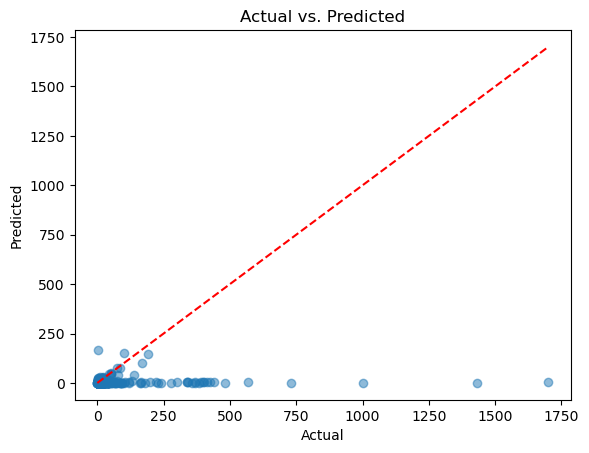

-------------------------------


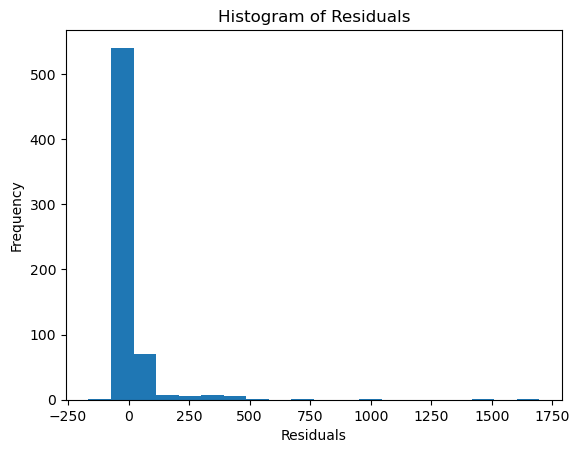

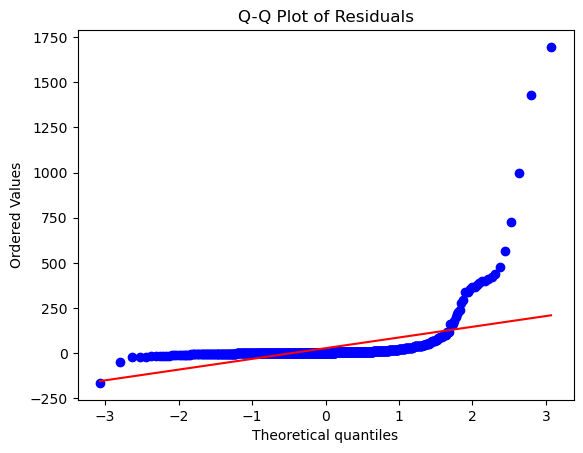

-------------------------------


In [83]:
'''Get all the performance metrics...'''

# Calculate the mean squared error and the root mean squared error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Calculate the variance of the target variable
target_variance = np.var(y_test)

# Calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)

# Print the metrics
print("MODEL PERFORMANCE METRICS")
print('-------------------------------')
print("Variance of the target variable:", target_variance)
print("MSE of the model:", mse)
# Compare the MSE to the variance
if mse < target_variance:
    print("The model's MSE is smaller than the variance of the target variable.")
    print("The model is capturing a significant portion of the variability in the target variable.")
else:
    print("The model's MSE is close to or larger than the variance of the target variable.")
    print("The model's performance may be limited compared to the variability of the target variable.")
print("RMSE of the model:", rmse)
print("MAE of the best KNN model:", mae)
print('-------------------------------')

# Quantile regression loss at 25th, 50th, and 75th percentiles
quantiles = [0.25, 0.5, 0.75]
quantile_losses = [np.percentile(np.abs(y_test - y_pred), q * 100) for q in quantiles]
print("Quantile regression loss:")
for q, loss in zip(quantiles, quantile_losses):
    print(f"Quantile {q}: {loss}")
print('-------------------------------')

# Define tolerance levels
tolerance_levels = [5, 10, 15, 20, 50]  # Percentage tolerance levels
tolerances = {level: level / 100 * np.mean(y_test) for level in tolerance_levels}

# Calculate performance range
performance_range = np.max(y_test) - np.min(y_test)

# Initialize counters for each tolerance level
within_tolerance = {level: 0 for level in tolerance_levels}

# Calculate the percentage of predictions within each tolerance level
for level, tol in tolerances.items():
    within_tolerance[level] = np.mean(np.abs(y_test - y_pred) <= tol) * 10

# Print results
print(f"Percentage of predictions within different tolerance levels:")
for level in tolerance_levels:
    print(f"±{level}%: {within_tolerance[level]:.2f}%")
print(f"Performance range: {performance_range:.2f}")

# Calculate percentage differences between predicted and actual values
percentage_diff = (np.abs(y_pred - y_test) / y_test) * 100

# Calculate the actual percentage range
min_percentage_range = np.min(percentage_diff)
max_percentage_range = np.max(percentage_diff)

# Calculate the percentage of predictions within each tolerance level
within_tolerance = {level: np.mean(percentage_diff <= level) * 100 for level in tolerance_levels}

# Print results
print(f"Minimum percentage difference: {min_percentage_range:.2f}%")
print(f"Maximum percentage difference: {max_percentage_range:.2f}%")
print('-------------------------------')

# Perform k-fold cross-validation
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert scores to positive values
cv_scores = -cv_scores

# Print cross-validation scores
print("Cross-validation MSE scores:", cv_scores)
print("Mean cross-validation MSE:", np.mean(cv_scores))
print('-------------------------------')

# Access feature importances if applicable (e.g., for decision tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importances = best_model.feature_importances_
    # Print feature importances
    print("Feature importances:")
    for feature, importance in zip(X.columns, feature_importances):
        print(f"{feature}: {importance}")
else:
    print("Feature importances are not available for this model.")
print('-------------------------------')

# Scatter plot of actual vs. predicted values
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()
print('-------------------------------')

# Calculate residuals
residuals = y_test - y_pred

# Plot histogram of residuals
plt.hist(residuals, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# Alternatively, you can also create a Q-Q plot of residuals
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()
print('-------------------------------')

### Establishing function for running models for each Basin given certain variable inputs

In [92]:
def generate_knn_models_by_basin(df, round, basins, columns_to_drop, categorical_columns,test_size, random_state, k_values):
    
    '''Finalize data preprocessing per input variables / requirements of KNN regression model'''

    # Drop unnecessary columns
    df_starting = df.drop(columns_to_drop, axis=1)
    
    for basin in basins:
        
        print('===============================')
        print(f'{basin}')
        print('===============================')

        '''--------------------------------------------------------------------------------------------------------------'''
        '''Finalize data preprocessing per input variables / requirements of KNN regression model'''

        # Drop rows from anything that isn't the 'basin' at hand
        df_basin = df_starting[df_starting['BASIN_CATEGORY'] == basin]

        # Drop the 'BASIN_CATEGORY' column as it is no longer needed
        df_basin.drop('BASIN_CATEGORY', axis=1, inplace=True)

        # Drop null values in the 'Li' (target) column
        df_basin.dropna(subset=['Li'], inplace=True)

        # Drop any remaining null values
        df_basin.dropna(inplace=True)

        # Get the remaining number of rows
        num_rows = df_basin.shape[0]
        print("Number of data points: ", num_rows)

        '''--------------------------------------------------------------------------------------------------------------'''
        '''Encode categorical features'''

        # One-hot encode categorical variables
        df_basin = pd.get_dummies(df_basin, columns=categorical_columns, dtype=int)

        '''--------------------------------------------------------------------------------------------------------------'''
        '''Split testing/training sets'''

        # Splitting the data into features (X) and the target variable (y)
        y = df_basin['Li'].copy()                   # Target variable
        X = df_basin.drop(columns=['Li']).copy()    # Features

        # Splitting the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        
        '''--------------------------------------------------------------------------------------------------------------'''
        '''Scale features'''

        # Standardize features by removing the mean and scaling to unit variance
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        '''--------------------------------------------------------------------------------------------------------------'''
        '''Train & test model'''

        # Create a parameter grid
        param_grid = {'n_neighbors': k_values}

        # Perform grid search with cross-validation
        grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train_scaled, y_train)

        # Get the best k value
        best_k = grid_search.best_params_['n_neighbors']
        print("Best k value:", best_k)

        # Get the best model
        best_model = grid_search.best_estimator_

        # Evaluate the best model
        y_pred = best_model.predict(X_test_scaled)
        
        '''--------------------------------------------------------------------------------------------------------------'''
        '''Get all the performance metrics...'''

        # Calculate the mean squared error and the root mean squared error
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        # Calculate the variance of the target variable
        target_variance = np.var(y_test)

        # Calculate the mean absolute error
        mae = mean_absolute_error(y_test, y_pred)

        # Print the metrics
        print('-------------------------------')
        print("MODEL PERFORMANCE METRICS")
        print('-------------------------------')
        print("Variance of the target variable:", target_variance)
        print("MSE of the model:", mse)
        # Compare the MSE to the variance
        if mse < target_variance:
            print("The model's MSE is smaller than the variance of the target variable.")
            print("The model is capturing a significant portion of the variability in the target variable.")
        else:
            print("The model's MSE is close to or larger than the variance of the target variable.")
            print("The model's performance may be limited compared to the variability of the target variable.")
        print("RMSE of the model:", rmse)
        print("MAE of the best KNN model:", mae)
        print('-------------------------------')

        # Quantile regression loss at 25th, 50th, and 75th percentiles
        quantiles = [0.25, 0.5, 0.75]
        quantile_losses = [np.percentile(np.abs(y_test - y_pred), q * 100) for q in quantiles]
        print("Quantile regression loss:")
        for q, loss in zip(quantiles, quantile_losses):
            print(f"Quantile {q}: {loss}")
        print('-------------------------------')

        # Define tolerance levels
        tolerance_levels = [5, 10, 15, 20, 50]  # Percentage tolerance levels
        tolerances = {level: level / 100 * np.mean(y_test) for level in tolerance_levels}

        # Calculate performance range
        performance_range = np.max(y_test) - np.min(y_test)

        # Initialize counters for each tolerance level
        within_tolerance = {level: 0 for level in tolerance_levels}

        # Calculate the percentage of predictions within each tolerance level
        for level, tol in tolerances.items():
            within_tolerance[level] = np.mean(np.abs(y_test - y_pred) <= tol) * 10

        # Print results
        print(f"Percentage of predictions within different tolerance levels:")
        for level in tolerance_levels:
            print(f"±{level}%: {within_tolerance[level]:.2f}%")
        print(f"Performance range: {performance_range:.2f}")

        # Calculate percentage differences between predicted and actual values
        percentage_diff = (np.abs(y_pred - y_test) / y_test) * 100

        # Calculate the actual percentage range
        min_percentage_range = np.min(percentage_diff)
        max_percentage_range = np.max(percentage_diff)

        # Calculate the percentage of predictions within each tolerance level
        within_tolerance = {level: np.mean(percentage_diff <= level) * 100 for level in tolerance_levels}

        # Print results
        print(f"Minimum percentage difference: {min_percentage_range:.2f}%")
        print(f"Maximum percentage difference: {max_percentage_range:.2f}%")
        print('-------------------------------')

        # Perform k-fold cross-validation
        cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

        # Convert scores to positive values
        cv_scores = -cv_scores

        # Print cross-validation scores
        print("Cross-validation MSE scores:", cv_scores)
        print("Mean cross-validation MSE:", np.mean(cv_scores))
        print('-------------------------------')

        # Scatter plot of actual vs. predicted values
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title('Actual vs. Predicted')
        plt.show()
        print('-------------------------------')

        # Calculate residuals
        residuals = y_test - y_pred

        # Plot histogram of residuals
        plt.hist(residuals, bins=20)
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.title('Histogram of Residuals')
        plt.show()

        # Alternatively, you can also create a Q-Q plot of residuals
        import scipy.stats as stats
        stats.probplot(residuals, dist="norm", plot=plt)
        plt.title('Q-Q Plot of Residuals')
        plt.show()
        print('-------------------------------')

    #     '''--------------------------------------------------------------------------------------------------------------'''
    #     '''Add results to a dataframe'''

    #     columns = ['round', 'basin', 'test_train_data_row_count','feature_quantity', 'feature_list', 'target_variable_variance', 'model_mse', 'delta_mse_vs_variance']

    #     df_results = pd.DataFrame(
    #         #...
    #     ).sort_values(by=['delta_mse_vs_variance'], ascending=True, inplace=True)

    # return df_results

### ROUND 1 | Let the iterating begin...

Appalachian
Number of data points:  81


Best k value: 2
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 19404.581984
MSE of the model: 14993.1416
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 122.4464846371671
MAE of the best KNN model: 36.54
-------------------------------
Quantile regression loss:
Quantile 0.25: 4.5
Quantile 0.5: 8.649999999999999
Quantile 0.75: 20.6
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 2.00%
±10%: 4.40%
±15%: 5.60%
±20%: 7.20%
±50%: 8.80%
Performance range: 721.50
Minimum percentage difference: 2.27%
Maximum percentage difference: 4120.00%
-------------------------------
Cross-validation MSE scores: [2539.876875   1310.21227273 3797.94        635.06363636  863.19068182]
Mean cross-validation MSE: 1829.2566931818178
-----------------------------

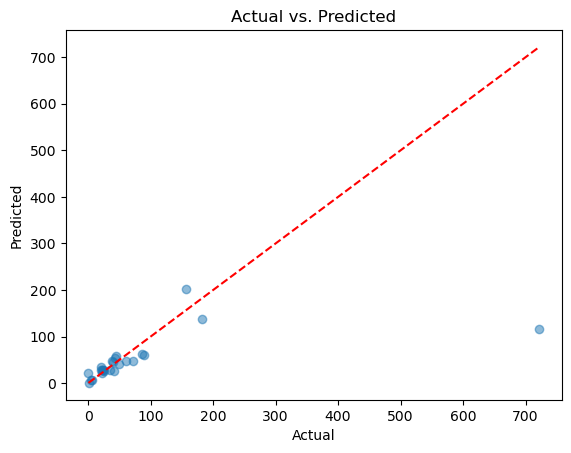

-------------------------------


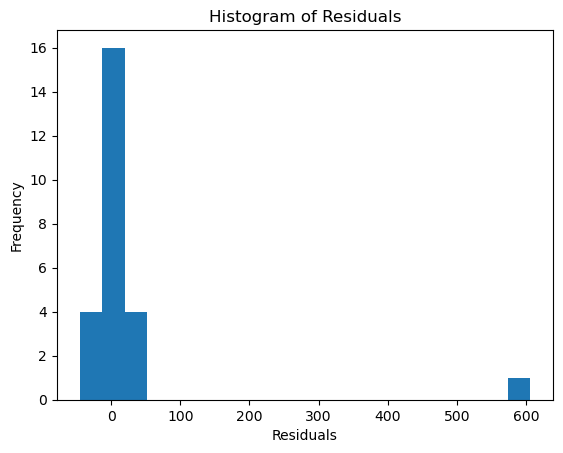

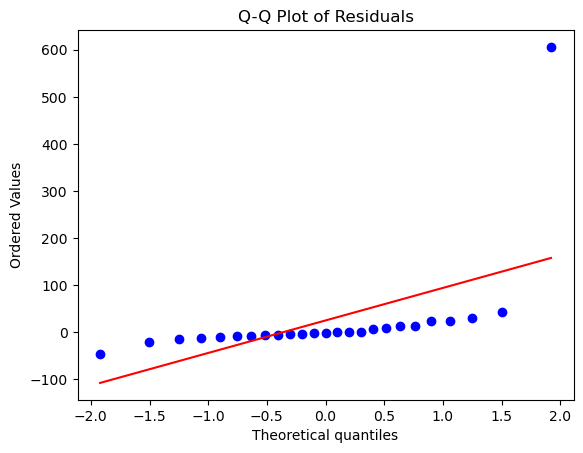

-------------------------------
Permian
Number of data points:  308
Best k value: 1
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 543.8570641923923
MSE of the model: 711.8973806451611
The model's MSE is close to or larger than the variance of the target variable.
The model's performance may be limited compared to the variability of the target variable.
RMSE of the model: 26.68140514750228
MAE of the best KNN model: 11.124731182795697
-------------------------------
Quantile regression loss:
Quantile 0.25: 1.1300000000000001
Quantile 0.5: 5.49
Quantile 0.75: 12.0
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 1.18%
±10%: 2.69%
±15%: 2.80%
±20%: 3.55%
±50%: 5.48%
Performance range: 220.20
Minimum percentage difference: 0.00%
Maximum percentage difference: 2213.18%
-------------------------------
Cross-validation MSE scores: [ 175.14366744  230.23086512  152.9297

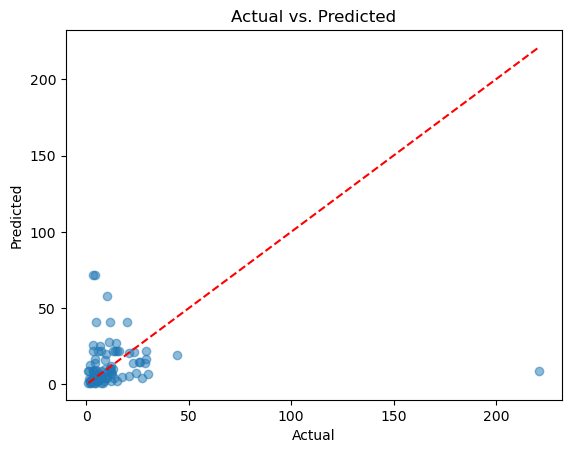

-------------------------------


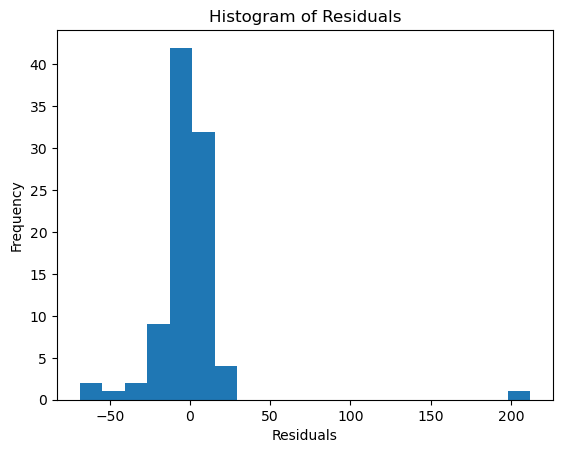

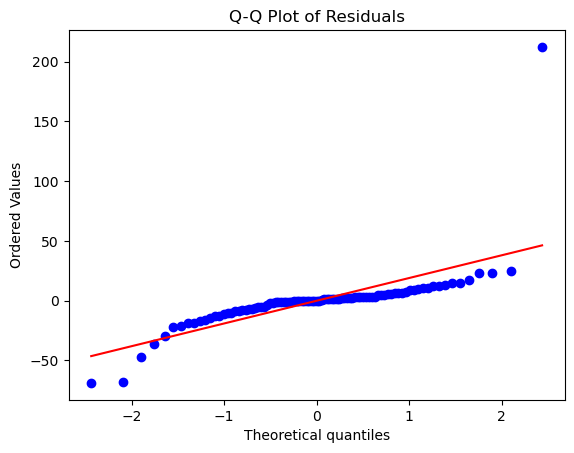

-------------------------------
Oklahoma Platform
Number of data points:  167
Best k value: 3
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 207.0968208381392
MSE of the model: 135.1735692810458
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 11.626416871979337
MAE of the best KNN model: 9.021633986928107
-------------------------------
Quantile regression loss:
Quantile 0.25: 4.126666666666666
Quantile 0.5: 6.2
Quantile 0.75: 12.221666666666668
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 0.78%
±10%: 0.98%
±15%: 1.57%
±20%: 1.76%
±50%: 5.88%
Performance range: 67.00
Minimum percentage difference: 0.00%
Maximum percentage difference: 1423.29%
-------------------------------
Cross-validation MSE scores: [231.64165324 444.86956232 163.

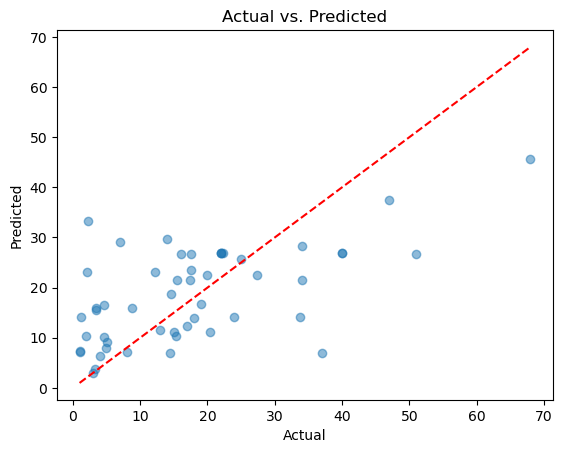

-------------------------------


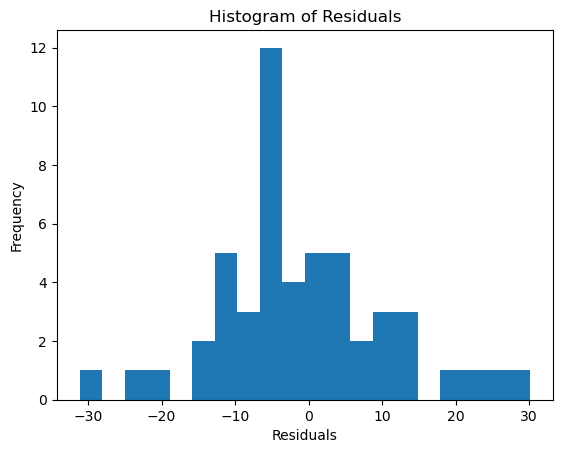

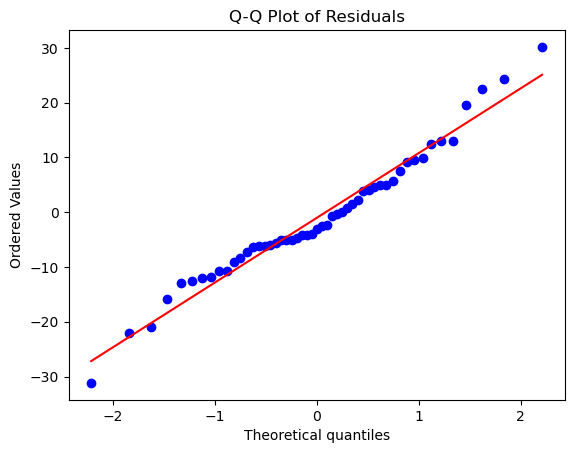

-------------------------------
Gulf Coast
Number of data points:  273
Best k value: 17
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 11637.99750792683
MSE of the model: 16410.8003546544
The model's MSE is close to or larger than the variance of the target variable.
The model's performance may be limited compared to the variability of the target variable.
RMSE of the model: 128.1046461087747
MAE of the best KNN model: 92.99331420373026
-------------------------------
Quantile regression loss:
Quantile 0.25: 3.958823529411765
Quantile 0.5: 75.11764705882351
Quantile 0.75: 174.37485294117647
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 1.83%
±10%: 3.17%
±15%: 3.66%
±20%: 3.66%
±50%: 4.27%
Performance range: 439.00
Minimum percentage difference: 3.70%
Maximum percentage difference: 7473.31%
-------------------------------
Cross-validation MSE scores: [72042.624

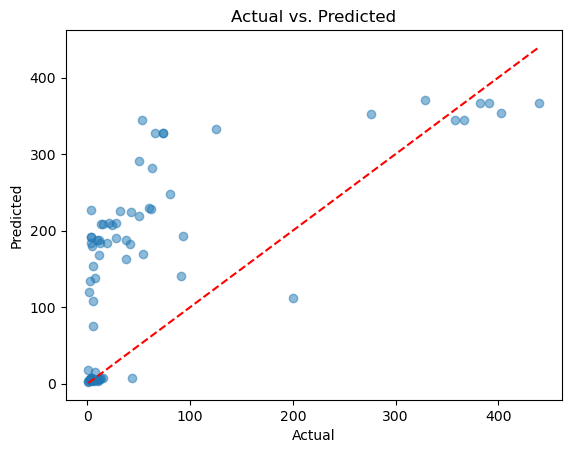

-------------------------------


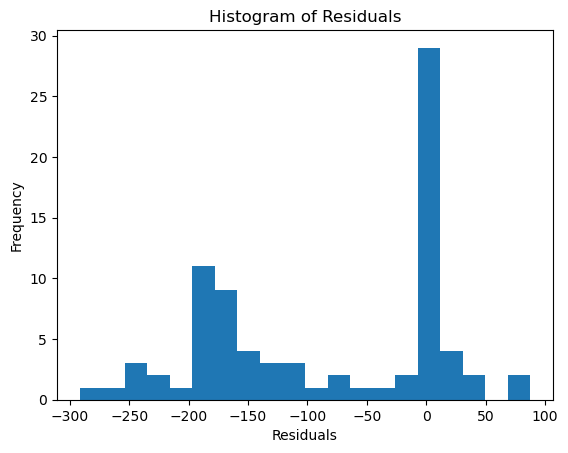

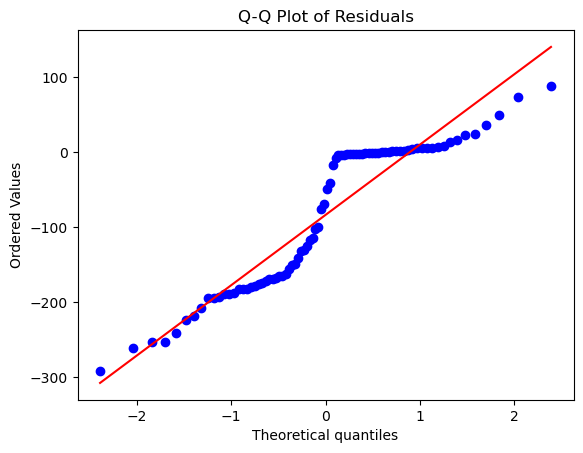

-------------------------------
Williston
Number of data points:  375
Best k value: 8
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 3069.407528764979
MSE of the model: 3563.318348396018
The model's MSE is close to or larger than the variance of the target variable.
The model's performance may be limited compared to the variability of the target variable.
RMSE of the model: 59.693536906402336
MAE of the best KNN model: 31.148805309734513
-------------------------------
Quantile regression loss:
Quantile 0.25: 2.798749999999999
Quantile 0.5: 10.5
Quantile 0.75: 30.987500000000004
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 1.95%
±10%: 2.74%
±15%: 3.36%
±20%: 3.89%
±50%: 6.28%
Performance range: 343.00
Minimum percentage difference: 0.00%
Maximum percentage difference: 2405.00%
-------------------------------
Cross-validation MSE scores: [2012.74949177 1923.55

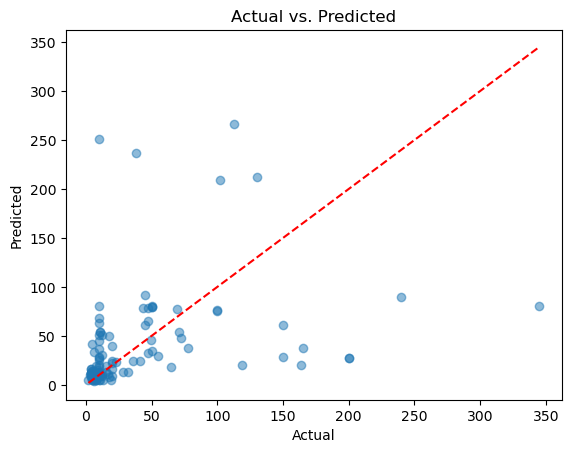

-------------------------------


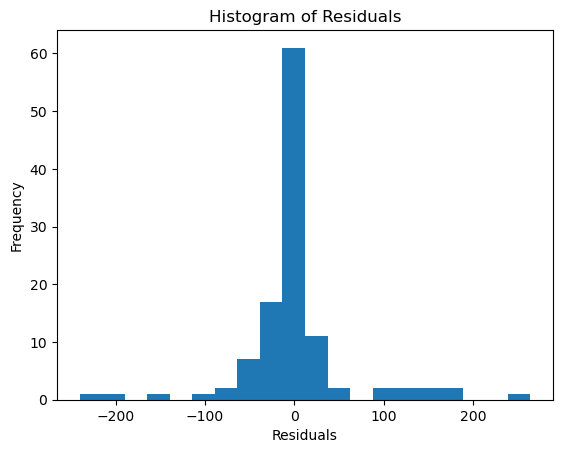

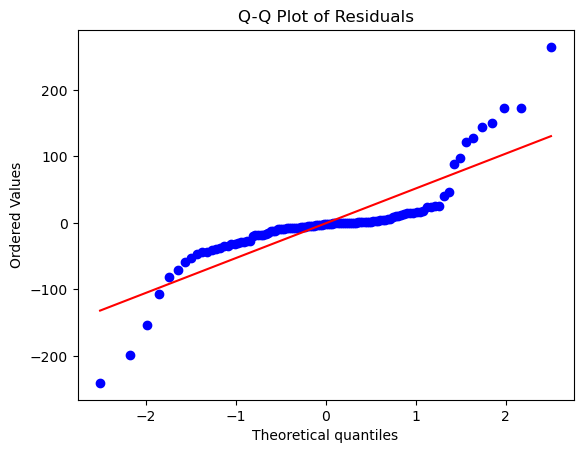

-------------------------------
Michigan
Number of data points:  59
Best k value: 7
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 850.9316200617284
MSE of the model: 569.0388990929706
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 23.854536237222693
MAE of the best KNN model: 14.829206349206352
-------------------------------
Quantile regression loss:
Quantile 0.25: 3.489285714285713
Quantile 0.5: 9.664285714285715
Quantile 0.75: 14.157142857142858
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 1.11%
±10%: 2.22%
±15%: 3.33%
±20%: 3.89%
±50%: 7.78%
Performance range: 118.00
Minimum percentage difference: 0.45%
Maximum percentage difference: 1271.43%
-------------------------------
Cross-validation MSE scores: [ 70.65239955 243.1233479

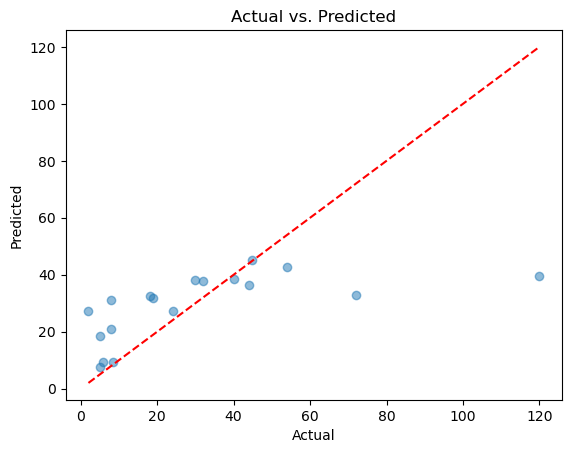

-------------------------------


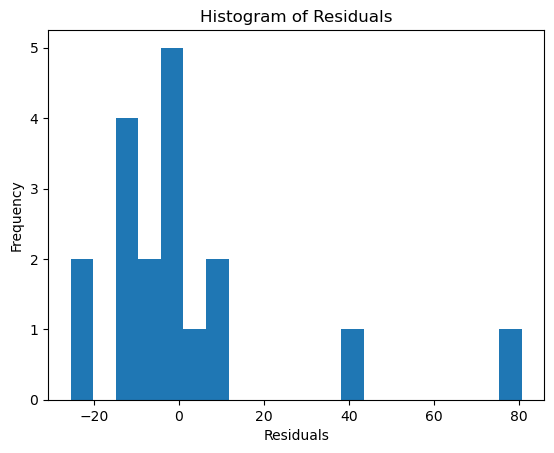

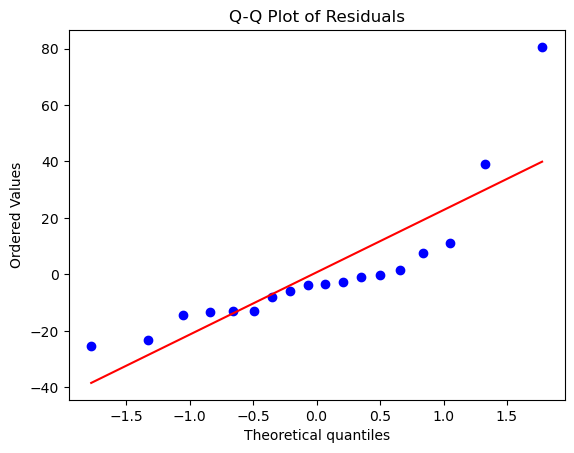

-------------------------------
Pacific
Number of data points:  100
Best k value: 1
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 0.5223848888888888
MSE of the model: 0.37890333333333337
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 0.6155512434666454
MAE of the best KNN model: 0.3516666666666667
-------------------------------
Quantile regression loss:
Quantile 0.25: 0.04250000000000004
Quantile 0.5: 0.14499999999999985
Quantile 0.75: 0.4475000000000001
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 3.67%
±10%: 4.33%
±15%: 6.33%
±20%: 6.67%
±50%: 8.33%
Performance range: 2.82
Minimum percentage difference: 0.00%
Maximum percentage difference: 350.00%
-------------------------------
Cross-validation MSE scores: [ 0.46378571  0.42788

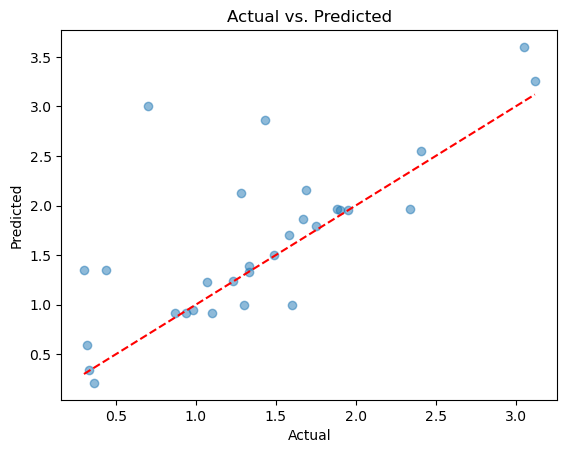

-------------------------------


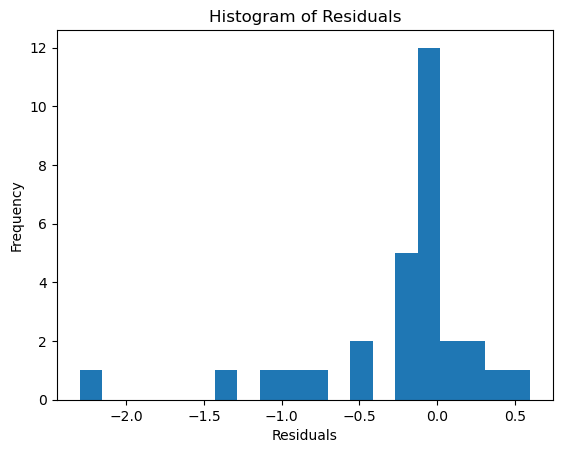

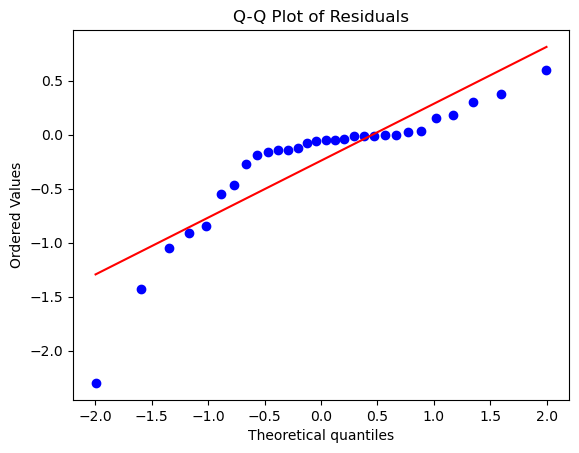

-------------------------------
Illinois
Number of data points:  15
Best k value: 6
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 215.832704
MSE of the model: 265.7650027777778
The model's MSE is close to or larger than the variance of the target variable.
The model's performance may be limited compared to the variability of the target variable.
RMSE of the model: 16.302300536359212
MAE of the best KNN model: 12.715666666666667
-------------------------------
Quantile regression loss:
Quantile 0.25: 5.798333333333333
Quantile 0.5: 7.031666666666666
Quantile 0.75: 17.081666666666667
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 0.00%
±10%: 0.00%
±15%: 0.00%
±20%: 2.00%
±50%: 6.00%
Performance range: 39.88
Minimum percentage difference: 58.37%
Maximum percentage difference: 273.51%
-------------------------------
Cross-validation MSE scores: [ 47.579425   595.4

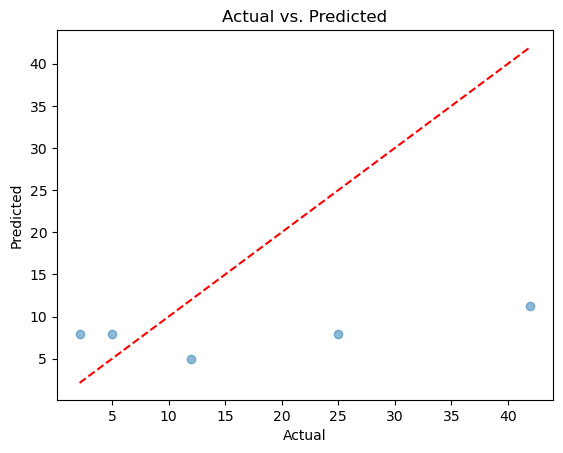

-------------------------------


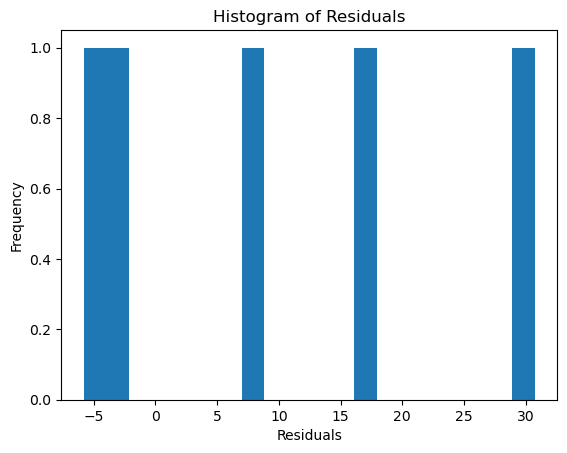

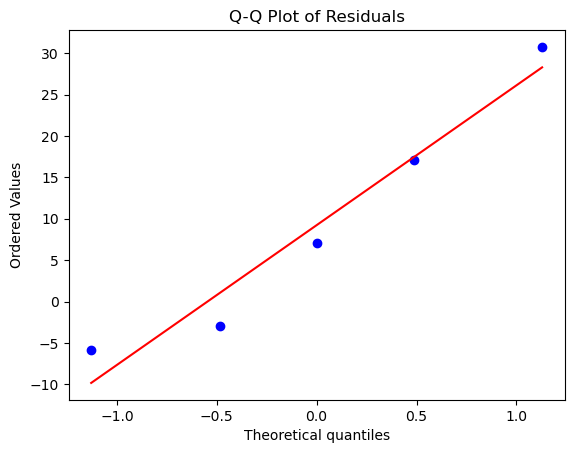

-------------------------------
Great Plains
Number of data points:  37
Best k value: 1
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 4.93820763888889
MSE of the model: 8.862575000000001
The model's MSE is close to or larger than the variance of the target variable.
The model's performance may be limited compared to the variability of the target variable.
RMSE of the model: 2.9770077258885306
MAE of the best KNN model: 2.3608333333333333
-------------------------------
Quantile regression loss:
Quantile 0.25: 1.0225
Quantile 0.5: 2.0
Quantile 0.75: 3.0
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 0.83%
±10%: 0.83%
±15%: 0.83%
±20%: 3.33%
±50%: 8.33%
Performance range: 6.30
Minimum percentage difference: 0.00%
Maximum percentage difference: 78.49%
-------------------------------
Cross-validation MSE scores: [3.81568000e+00 1.04877816e+05 6.21170000e+00 2.3215

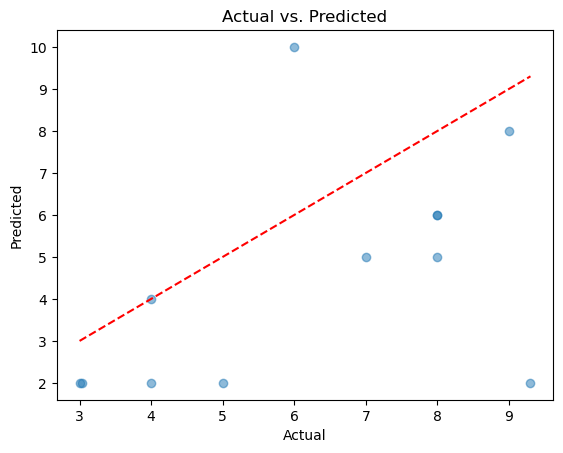

-------------------------------


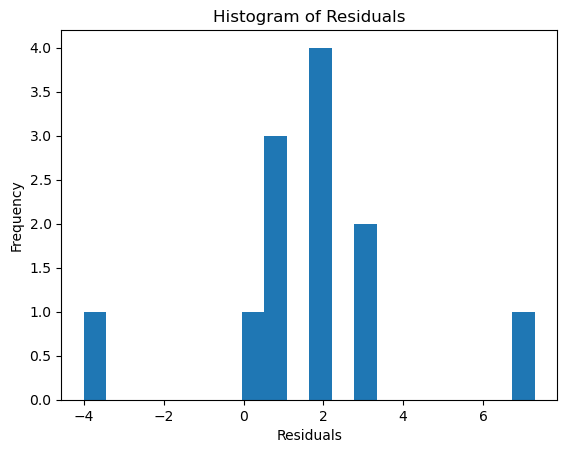

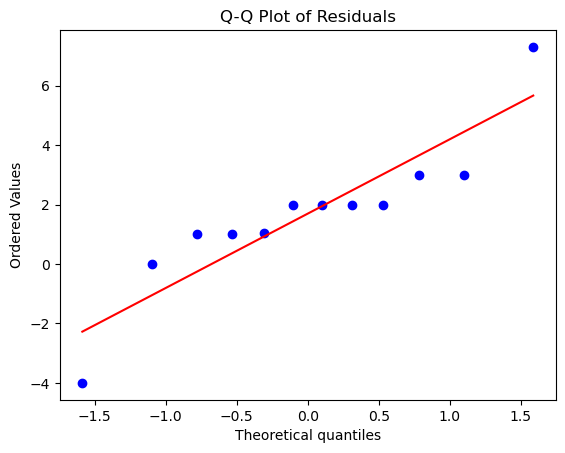

-------------------------------
Anadarko
Number of data points:  232
Best k value: 5
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 5763.469534204081
MSE of the model: 4325.166099485714
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 65.76599500871035
MAE of the best KNN model: 19.16071428571428
-------------------------------
Quantile regression loss:
Quantile 0.25: 0.2654999999999995
Quantile 0.5: 0.976
Quantile 0.75: 6.484999999999999
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 5.43%
±10%: 6.43%
±15%: 6.71%
±20%: 7.00%
±50%: 8.57%
Performance range: 479.00
Minimum percentage difference: 0.00%
Maximum percentage difference: 2949.60%
-------------------------------
Cross-validation MSE scores: [  544.4784223   2171.11801903  3202.8

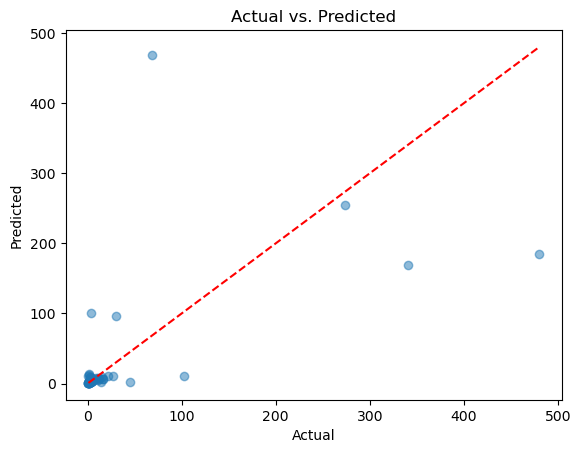

-------------------------------


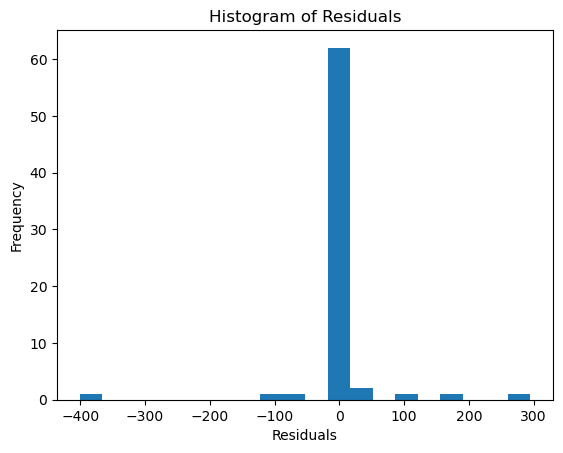

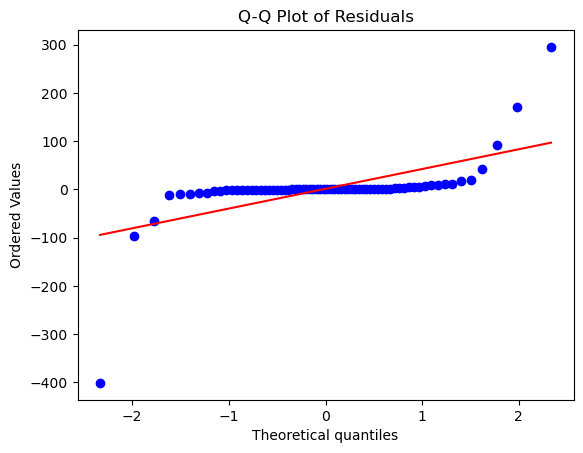

-------------------------------
Rocky Mountain
Number of data points:  621
Best k value: 13
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 159.26972425290978
MSE of the model: 147.12020979337402
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 12.129312008245728
MAE of the best KNN model: 6.7117359111476755
-------------------------------
Quantile regression loss:
Quantile 0.25: 2.0769230769230766
Quantile 0.5: 3.3876923076923067
Quantile 0.75: 6.515384615384616
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 0.48%
±10%: 0.91%
±15%: 1.55%
±20%: 2.14%
±50%: 5.94%
Performance range: 104.00
Minimum percentage difference: 0.00%
Maximum percentage difference: 1115.38%
-------------------------------
Cross-validation MSE scores: [115.67785315 

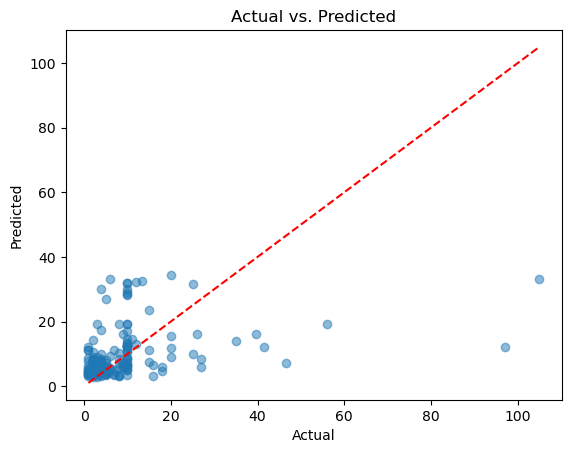

-------------------------------


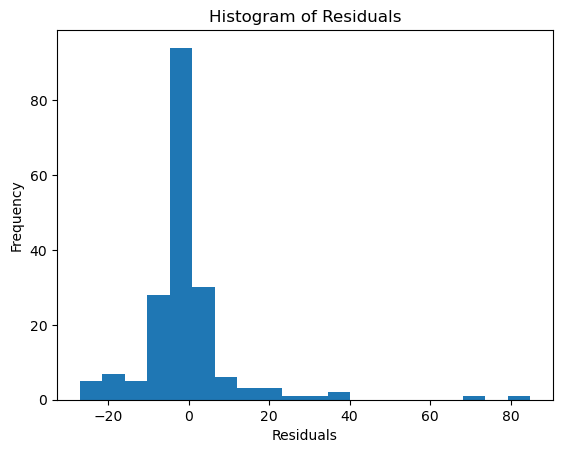

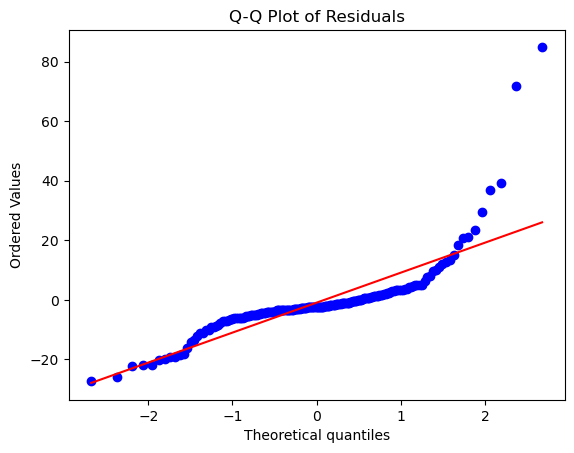

-------------------------------
Fort Worth
Number of data points:  9
Best k value: 1
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 140.2254222222222
MSE of the model: 7.6848
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 2.7721471822397885
MAE of the best KNN model: 2.6266666666666665
-------------------------------
Quantile regression loss:
Quantile 0.25: 2.0
Quantile 0.5: 2.0
Quantile 0.75: 2.94
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 0.00%
±10%: 0.00%
±15%: 6.67%
±20%: 6.67%
±50%: 10.00%
Performance range: 26.88
Minimum percentage difference: 6.90%
Maximum percentage difference: 183.02%
-------------------------------
Cross-validation MSE scores: [1875.76805    9.        16.         9.       615.5361 ]
Mean cross-validation

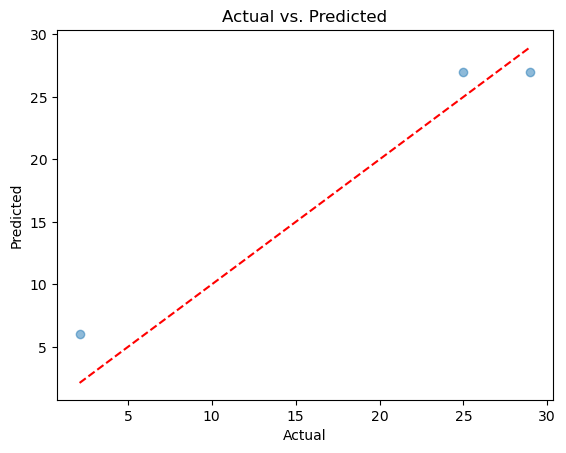

-------------------------------


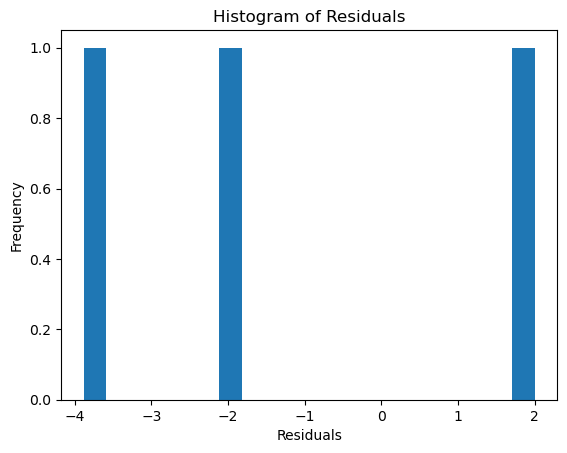

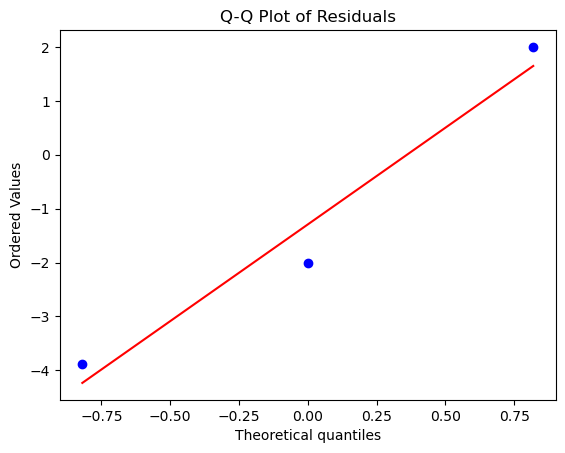

-------------------------------


In [93]:
# Define all the variables...
df = df_data.copy()
round = '01'
basins = df_data['BASIN_CATEGORY'].unique()
columns_to_drop = ['IDUSGS', 'PERIOD', 'DATESAMPLE', 'API', 'Ba', 'Zn', 'B', 'FeTot', 'DEPTHLOWER', 'Sr', 'Br', 'HCO3', 'WELLTYPE', 'STATE', 'WELLNAME']
categorical_columns = ['PLAYTYPE', 'FORMSIMPLE', 'COUNTY', 'PROVINCE', 'REGION']
test_size = 0.3
random_state = 42
k_values = list(range(1, 21))

# Run the function...
generate_knn_models_by_basin(df=df, round=round, basins=basins, columns_to_drop=columns_to_drop, categorical_columns=categorical_columns, test_size=test_size, random_state=random_state, k_values=k_values)

# # Run the function...
# df_round01 = generate_knn_models_by_basin(df=df, round=round, basins=basins, columns_to_drop=columns_to_drop, categorical_columns=categorical_columns, 
#                                           test_size=test_size, random_state=random_state, k_values=k_values)
# df_round01

### Merge all results dfs into 1 large df for evaluation

In [ ]:
rounds = [df_round01, '''...''']
columns = ['round', 'basin', 'test_train_data_row_count','feature_quantity', 'feature_list', 'target_variable_variance', 'model_mse', 'delta_mse_vs_variance']

for round in rounds:
    df_results = #...
    

In [ ]:
# Identify best round # for each basin
#...